## importar la base


In [14]:
import pandas as pd

taxi_data = pd.read_csv("yellow_tripdata_2021-12.csv")

taxi_data.head()

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1724\4079691695.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi_data = pd.read_csv("yellow_tripdata_2021-12.csv")


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-12-01 00:19:51,2021-12-01 00:37:01,1.0,9.30,1.0,N,138,141,1,26.5,4.25,0.5,7.60,6.55,0.3,45.70,2.5,1.25
1,2,2021-12-01 00:29:07,2021-12-01 00:45:13,2.0,2.76,1.0,N,238,42,2,13.0,0.50,0.5,0.00,0.00,0.3,16.80,2.5,0.00
2,1,2021-12-01 00:12:40,2021-12-01 00:27:17,0.0,3.40,1.0,N,239,74,1,13.5,3.00,0.5,2.00,0.00,0.3,19.30,2.5,0.00
3,1,2021-12-01 00:10:18,2021-12-01 00:19:20,1.0,1.30,1.0,N,148,87,1,6.5,3.00,0.5,2.05,0.00,0.3,12.35,2.5,0.00
4,1,2021-12-01 00:25:12,2021-12-01 00:39:07,1.0,3.10,1.0,N,231,246,1,12.5,3.00,0.5,2.50,0.00,0.3,18.80,2.5,0.00


## Cosas a calcular

- Duración de Viajes: Podemos calcularla usando tpep_pickup_datetime y tpep_dropoff_datetime.
- % Rates: La columna RatecodeID indica el tipo de tarifa.
- Viajes Inter e Intra Boroughs: Utilizando PULocationID y DOLocationID, podemos determinar si los viajes son dentro de un mismo borough o entre diferentes boroughs.
- Días, Días de la Semana y Semanas con Más Viajes: Podemos analizar tpep_pickup_datetime para obtener esta información.
- Trip Distance por Passenger: trip_distance y passenger_count nos ayudarán aquí.
- Avg Tips por Passenger: Usaremos tip_amount y passenger_count.
- % Payment Types: La columna payment_type contiene esta información.
- Borough con Mayor/Menor Cantidad de Viajes: Se puede determinar a partir de PULocationID y DOLocationID.
- Viajes Entre Distintas Zonas: Nuevamente, PULocationID y DOLocationID son relevantes aquí.

## Duracion viajes

In [15]:
import numpy as np

# Convertir  pickup y dropoff datetime a pandas datetime 
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
taxi_data['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data['tpep_dropoff_datetime'])

# Clacular duracion del viaje en minutos
taxi_data['trip_duration'] = (taxi_data['tpep_dropoff_datetime'] - taxi_data['tpep_pickup_datetime']).dt.total_seconds() / 60

# Resumir estadisticos
trip_duration_stats = taxi_data['trip_duration'].describe()

trip_duration_stats

count    3.214369e+06
mean     1.744226e+01
std      8.316935e+01
min     -1.044726e+05
25%      7.233333e+00
50%      1.200000e+01
75%      1.940000e+01
max      2.933652e+04
Name: trip_duration, dtype: float64

Hay valores negativos como minimos, indica mala calidad del dato. Hay que corregirlo

## % de tarifas

In [16]:
# calcular las distribucion de las tarifas
rate_code_distribution = taxi_data['RatecodeID'].value_counts(normalize=True) * 100

rate_code_distribution



RatecodeID
1.0     95.442189
2.0      3.394347
5.0      0.656202
3.0      0.290264
99.0     0.109640
4.0      0.106395
6.0      0.000964
Name: proportion, dtype: float64

En función del dicionario de codigos la interpretación sería esta 

- La distribución porcentual de los diferentes tipos de tarifas (Rate Codes) en los viajes de taxi es la siguiente:

* Tarifa Estándar (Rate Code 1): 95.44%
* JFK (Rate Code 2): 3.39%
* Tarifa Negociada (Rate Code 5): 0.66%
* Newark (Rate Code 3): 0.29%
* Otros (Rate Code 99): 0.11%
* Nassau o Westchester (Rate Code 4): 0.11%
* Viaje en Grupo (Rate Code 6): 0.001%

es decir, en términos de limpieza convendría cambiar el codigo por la etiqueta específica.

## Viajes Inter e Intra Boroughs

en este caso se debe usar la tabla de referencia que es taxi+_zone_lookup (1). hay que revisarla

In [17]:
taxi_zone_lookup_file = 'taxi+_zone_lookup (1).csv'
taxi_zone_lookup = pd.read_csv(taxi_zone_lookup_file)

taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [18]:
#Fusionar bases para identificar locaciones
taxi_data_with_boroughs = taxi_data.merge(taxi_zone_lookup[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID', how='left')
taxi_data_with_boroughs.rename(columns={'Borough': 'pickup_borough'}, inplace=True)
taxi_data_with_boroughs = taxi_data_with_boroughs.merge(taxi_zone_lookup[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID', how='left')
taxi_data_with_boroughs.rename(columns={'Borough': 'dropoff_borough'}, inplace=True)

# Determinar si son intra o inter
taxi_data_with_boroughs['borough_trip_type'] = np.where(taxi_data_with_boroughs['pickup_borough'] == taxi_data_with_boroughs['dropoff_borough'], 'Intra-Borough', 'Inter-Borough')

# calcular porcentaje vs
borough_trip_distribution = taxi_data_with_boroughs['borough_trip_type'].value_counts(normalize=True) * 100

borough_trip_distribution

borough_trip_type
Intra-Borough    86.065601
Inter-Borough    13.934399
Name: proportion, dtype: float64

el 86.07% de los viajes son intra-borough (dentro del mismo borough) y el 13.93% son inter-borough (entre diferentes boroughs).

## Días, Días de la Semana y Semanas con Más Viajes:

In [19]:
# Extraer el día de la semana, el día y la semana del año de la fecha de recogida
taxi_data['day_of_week'] = taxi_data['tpep_pickup_datetime'].dt.day_name()
taxi_data['day'] = taxi_data['tpep_pickup_datetime'].dt.day
taxi_data['week_of_year'] = taxi_data['tpep_pickup_datetime'].dt.isocalendar().week

# Calcular el número de viajes por día de la semana
trips_by_day_of_week = taxi_data['day_of_week'].value_counts().sort_index()

# Calcular el número de viajes por día
trips_by_day = taxi_data['day'].value_counts().sort_index()

# Calcular el número de viajes por semana del año
trips_by_week_of_year = taxi_data['week_of_year'].value_counts().sort_index()

trips_by_day_of_week, trips_by_day, trips_by_week_of_year


(day_of_week
 Friday       533896
 Monday       388083
 Saturday     413743
 Sunday       362727
 Thursday     555474
 Tuesday      415052
 Wednesday    545394
 Name: count, dtype: int64,
 day
 1     122013
 2     128647
 3     136234
 4     132392
 5     109655
 6     112665
 7     126652
 8     131662
 9     134724
 10    133497
 11    130247
 12    107169
 13    111299
 14    120218
 15    125049
 16    126270
 17    124150
 18    110279
 19     91200
 20     94213
 21     93093
 22     91702
 23     87850
 24     69620
 25     40807
 26     54705
 27     69897
 28     75037
 29     74989
 30     78022
 31     70412
 Name: count, dtype: int64,
 week_of_year
 1         28
 3          6
 4          1
 6          4
 7          1
 48    628964
 49    876612
 50    808461
 51    531986
 52    368306
 Name: count, dtype: Int64)

* Viajes por Día de la Semana
- Lunes: 388,083 viajes
- Martes: 415,052 viajes
- Miércoles: 545,394 viajes
- Jueves: 555,474 viajes
- Viernes: 533,896 viajes
- Sábado: 413,743 viajes
- Domingo: 362,727 viajes
- **Los días jueves y viernes son los de mayor actividad.**

* Viajes por Día del Mes
- Los viajes varían cada día del mes, con un pico generalmente a principios de mes y una disminución hacia el final del mes.

* Viajes por Semana del Año
- Semana 48: 628,964 viajes
- Semana 49: 876,612 viajes
- Semana 50: 808,461 viajes
- Semana 51: 531,986 viajes
- Semana 52: 368,306 viajes

- La semana 49 (principios de diciembre) muestra el mayor número de viajes.

## Trip Distance por Passenger

eliminar valores con pasajeros = 0

In [20]:
# Excluir registros con 0 pasajeros
taxi_data_valid_passengers = taxi_data[taxi_data['passenger_count'] > 0]

#  calcular la distancia promedio de viaje por cantidad de pasajeros
avg_trip_distance_by_passenger_valid = taxi_data_valid_passengers.groupby('passenger_count')['trip_distance'].mean()

avg_trip_distance_by_passenger_valid


passenger_count
1.0    3.217241
2.0    3.804809
3.0    3.634856
4.0    3.884603
5.0    3.347123
6.0    3.428150
7.0    4.145714
8.0    8.210000
9.0    0.000000
Name: trip_distance, dtype: float64

- La interpretación de estos datos sugiere que, en promedio, los viajes con más pasajeros tienden a ser más largos. Es interesante notar que hay un aumento significativo en la distancia promedio para viajes con 8 pasajeros, aunque este valor podría estar influenciado por un número menor de registros y debería interpretarse con precaución.

## Propinas promedio por pasajero

In [21]:
avg_tip_by_passenger = taxi_data_valid_passengers.groupby('passenger_count')['tip_amount'].mean()

avg_tip_by_passenger

passenger_count
1.0     2.529095
2.0     2.756858
3.0     2.641698
4.0     2.612600
5.0     2.619648
6.0     2.624807
7.0     6.671429
8.0     8.451667
9.0    19.560000
Name: tip_amount, dtype: float64

La propina promedio parece incrementar con el número de pasajeros, aunque esto podría estar influenciado por un número menor de registros para grupos más grandes de pasajeros. Es notable que el promedio de propinas aumenta significativamente para grupos de 7, 8 y especialmente 9 pasajeros, lo cual podría sugerir viajes más largos o especiales que involucran a grupos más grandes.

## Tipos de pago

In [22]:
# calculo de diferentes porcentajes
payment_type_distribution = taxi_data['payment_type'].value_counts(normalize=True) * 100

payment_type_distribution



payment_type
1    73.480829
2    22.416126
0     3.184793
3     0.498200
4     0.420020
5     0.000031
Name: proportion, dtype: float64

1. Pago con Tarjeta de Crédito (Tipo 1): 73.48%
2. Pago en Efectivo (Tipo 2): 22.42%
3. Sin Cargo (Tipo 3): 0.50%
4. Disputa (Tipo 4): 0.42%
5. Desconocido o No Especificado (Tipo 5): 0.00%
- La mayoría de los pagos se realizan con tarjeta de crédito, seguidos por pagos en efectivo. Los otros tipos de pago representan una pequeña fracción del total.

Cambiar la variable del codigo de pago a la respectiva etiqueta

## Borough con mayor cantidad de viajes

In [23]:
# unir datos
taxi_data_pickup_boroughs = taxi_data.merge(taxi_zone_lookup[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID', how='left')

# Calcular los viajes que se originan en cada distrito
trips_by_pickup_borough = taxi_data_pickup_boroughs['Borough'].value_counts()

# identificar mayores y menores y sus conteos
most_trips_borough = trips_by_pickup_borough.idxmax()
least_trips_borough = trips_by_pickup_borough.idxmin()
most_trips_count = trips_by_pickup_borough.max()
least_trips_count = trips_by_pickup_borough.min()

most_trips_borough, most_trips_count, least_trips_borough, least_trips_count



('Manhattan', 2889263, 'Staten Island', 224)

Manhattan es el borough con la mayor cantidad de viajes, con un total de 2,889,263 viajes, mientras que Staten Island tiene la menor cantidad de viajes, con solo 224 viajes.

dado que Manhattan es el centro más activo de la ciudad de Nueva York en términos de negocios, turismo y vida nocturna, lo que lleva a un mayor número de viajes de taxis. Por otro lado, Staten Island, siendo más residencial y menos accesible en comparación con otros boroughs, registra menos viajes de taxi.

## Viajes entre distintas zonas

In [24]:
# Fusiona la información de las zonas con los datos de taxi
taxi_data = taxi_data.merge(taxi_zone_lookup[['LocationID', 'Zone']], left_on='PULocationID', right_on='LocationID', how='left')
taxi_data.rename(columns={'Zone': 'pickup_zone'}, inplace=True)
taxi_data = taxi_data.merge(taxi_zone_lookup[['LocationID', 'Zone']], left_on='DOLocationID', right_on='LocationID', how='left')
taxi_data.rename(columns={'Zone': 'dropoff_zone'}, inplace=True)

# Calcula la cantidad de viajes entre cada par único de zonas de recogida y destino
zone_trip_counts = taxi_data.groupby(['pickup_zone', 'dropoff_zone']).size().reset_index(name='trip_count')

# Ordena los resultados para encontrar los pares de zonas con más viajes
zone_trip_counts = zone_trip_counts.sort_values(by='trip_count', ascending=False)

# Muestra los primeros resultados para ver los pares de zonas más populares
print(zone_trip_counts.head(10))

                 pickup_zone           dropoff_zone  trip_count
22318  Upper East Side South  Upper East Side North       23761
22098  Upper East Side North  Upper East Side South       19885
22319  Upper East Side South  Upper East Side South       15637
22097  Upper East Side North  Upper East Side North       15130
16349                     NV                     NV       12209
22253  Upper East Side South         Midtown Center        9500
22648  Upper West Side South    Lincoln Square East        8996
12709    Lincoln Square East  Upper West Side South        8708
22724  Upper West Side South  Upper West Side North        8699
12482        Lenox Hill West  Upper East Side North        8217


hay que limpiar los que son solo ny y no determinan distrito

- Upper East Side South a Upper East Side North (23,761 viajes): Este es el par de zonas más popular, lo cual sugiere una alta frecuencia de viajes cortos dentro del Upper East Side, probablemente debido a la densidad de población y la actividad comercial en esta área.

- Upper East Side North a Upper East Side South (19,885 viajes): Similar al punto anterior, pero en la dirección opuesta, lo que refuerza la idea de que hay una gran cantidad de viajes locales en esta área.

- Upper East Side South a Upper East Side South (15,637 viajes): Este número significativo de viajes que comienzan y terminan en la misma zona (Upper East Side South) indica una alta demanda de viajes muy locales, posiblemente debido a desplazamientos cortos donde el taxi es preferido sobre otras formas de transporte.

- Upper East Side North a Upper East Side North (15,130 viajes): Similar al punto anterior, pero en la zona norte del Upper East Side.

- NV a NV (12,209 viajes): "NV" probablemente representa registros donde la zona no fue especificada o es desconocida. La alta cantidad de estos registros sugiere que hay un número significativo de viajes donde la información de la zona no está disponible o no se registró correctamente.

- Upper East Side South a Midtown Center (9,500 viajes): Este flujo de viajes sugiere una fuerte conexión entre el Upper East Side South y Midtown Center, posiblemente debido a desplazamientos laborales o actividades de ocio y compras, ya que Midtown es conocido por sus numerosos puntos de interés y oficinas.

- Upper West Side South a Lincoln Square East (8,996 viajes): Este par indica una frecuencia alta de viajes entre estas dos áreas adyacentes del Upper West Side. Esto podría reflejar la movilidad local para actividades diarias como ir al trabajo, escuela, o entretenimiento.

- Lincoln Square East a Upper West Side South (8,708 viajes): Similar al punto anterior pero en dirección opuesta, reafirmando la conexión fuerte entre estas dos áreas.

- Upper West Side South a Upper West Side North (8,699 viajes): Este es otro ejemplo de alta demanda de viajes dentro de una misma área general, en este caso, dentro del Upper West Side, lo que podría indicar una preferencia por el taxi para viajes cortos en esta zona residencial y comercial.

- Lenox Hill West a Upper East Side North (8,217 viajes): Este par muestra una conexión significativa entre Lenox Hill West y Upper East Side North. Dado que ambas áreas son principalmente residenciales pero también cercanas a importantes hospitales, parques y lugares de interés cultural, estos viajes pueden representar una mezcla de actividades diarias, visitas médicas y ocio.



Preferencia por Viajes Cortos y Locales: La mayoría de los viajes son entre zonas cercanas o incluso dentro de la misma zona (como es el caso de Upper East Side y Upper West Side). Esto sugiere que los taxis son frecuentemente utilizados para desplazamientos cortos, probablemente debido a la conveniencia, rapidez y facilidad de acceso a los taxis en estas áreas.

Concentración en Áreas de Alta Densidad Residencial y Comercial: Las zonas mencionadas, especialmente Upper East Side, Upper West Side, Midtown y Lincoln Square, son conocidas por su alta densidad residencial y comercial. Esto implica que los viajes en taxi están en gran medida asociados con actividades cotidianas como ir al trabajo, compras, citas médicas, y ocio.

Flujo Bidireccional entre Zonas Cercanas: Existe un patrón de flujo bidireccional entre zonas adyacentes, como Upper East Side South y North, y Upper West Side South y Lincoln Square East. Esto indica que los viajes en taxi no están limitados a una dirección específica, reflejando la naturaleza dinámica de los desplazamientos urbanos.

Registros No Verificados (NV): La presencia de un número significativo de viajes etiquetados como "NV" (probablemente "No Verificado" o "No Disponible") sugiere que hay una parte de los datos donde la información de la zona no está disponible o no se registró correctamente.

Conexión entre Zonas Residenciales y de Negocios: Algunos de los viajes más populares conectan zonas residenciales con zonas de negocios o comerciales, como es el caso de Upper East Side South a Midtown Center. Esto puede estar relacionado con los patrones de desplazamiento para el trabajo o para actividades de ocio y compras.

## Viajes por hora

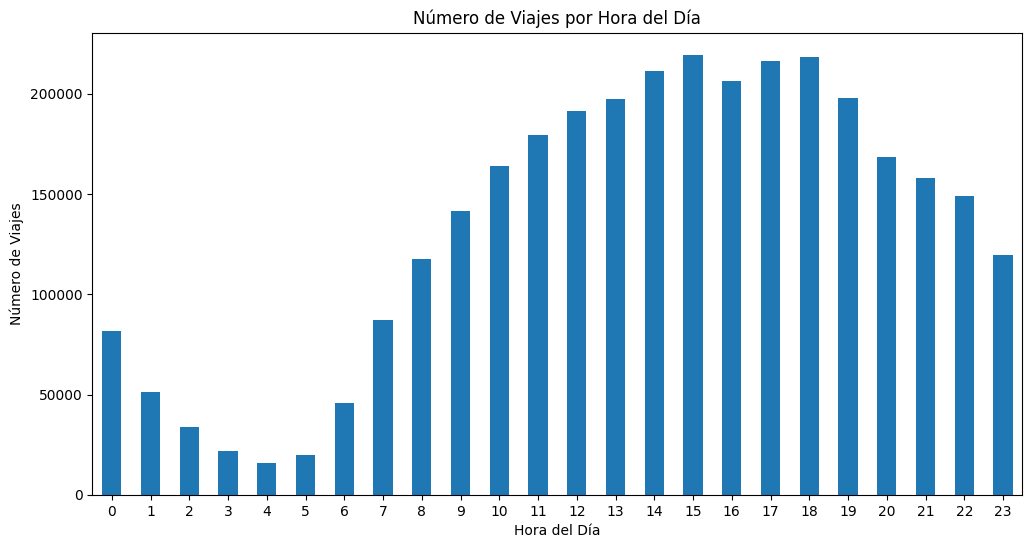

In [25]:
# Extraer la hora del día de la fecha y hora de recogida
taxi_data['hour_of_day'] = taxi_data['tpep_pickup_datetime'].dt.hour

# Contar los viajes por hora del día
trips_by_hour_of_day = taxi_data['hour_of_day'].value_counts().sort_index()

# Visualizar los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
trips_by_hour_of_day.plot(kind='bar')
plt.title('Número de Viajes por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Viajes')
plt.xticks(range(0, 24), rotation=0)
plt.show()


## Viajes por mes 

va a servir cuando las bases estén pegadas

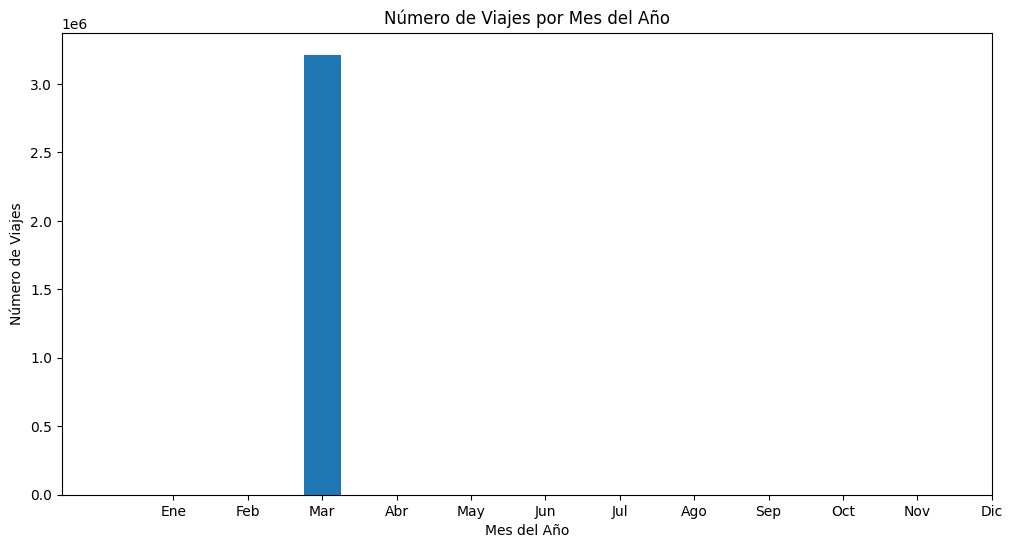

In [27]:
# Extraer el mes del año de la fecha y hora de recogida
taxi_data['month_of_year'] = taxi_data['tpep_pickup_datetime'].dt.month

# Contar los viajes por mes del año
trips_by_month_of_year = taxi_data['month_of_year'].value_counts().sort_index()

# Visualizar los resultados
plt.figure(figsize=(12, 6))
trips_by_month_of_year.plot(kind='bar')
plt.title('Número de Viajes por Mes del Año')
plt.xlabel('Mes del Año')
plt.ylabel('Número de Viajes')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
plt.show()


## estudio detallado de las tarifas y las propinas

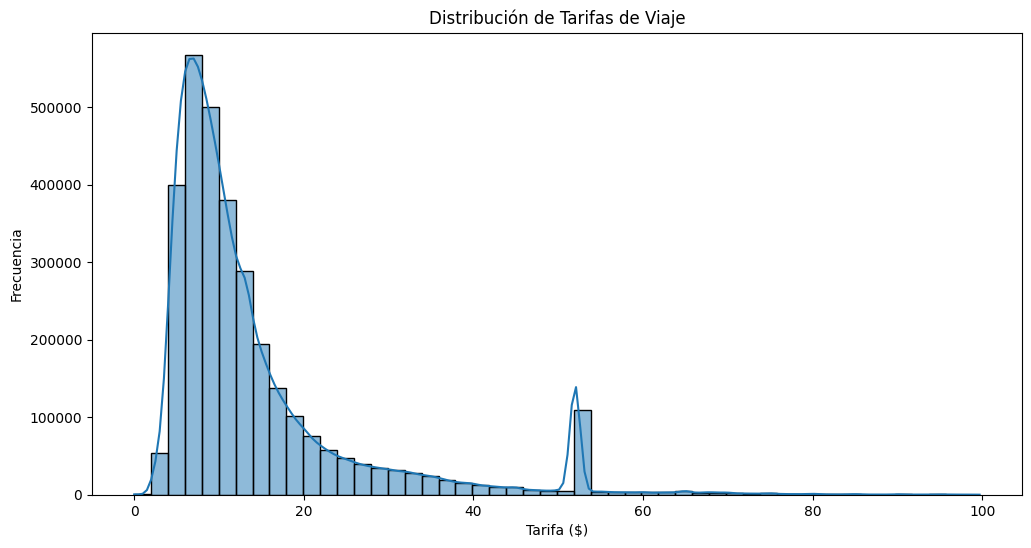

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar tarifas anormalmente altas o bajas 
taxi_data = taxi_data[(taxi_data['fare_amount'] > 0) & (taxi_data['fare_amount'] < 100)]

# Visualizar la distribución de las tarifas de viaje
plt.figure(figsize=(12, 6))
sns.histplot(taxi_data['fare_amount'], bins=50, kde=True)
plt.title('Distribución de Tarifas de Viaje')
plt.xlabel('Tarifa ($)')
plt.ylabel('Frecuencia')
plt.show()


Distribución Principal: La mayor frecuencia de las tarifas se concentra en el rango más bajo, con un pico prominente alrededor de los $10. Esto sugiere que la mayoría de los viajes en taxi tienen tarifas relativamente bajas, lo cual es consistente con viajes cortos o dentro de una misma zona urbana.

Cola Larga: La distribución tiene una cola larga hacia la derecha, lo que indica que hay una cantidad menor de viajes con tarifas mucho más altas. Estos viajes podrían ser más largos, como por ejemplo, viajes hacia o desde aeropuertos o viajes entre ciudades dentro de la región metropolitana.

Pico Secundario: Hay un pico secundario alrededor de los $52, que es bastante inusual. Este pico puede representar una tarifa fija que se aplica comúnmente para ciertos viajes largos y preestablecidos, como por ejemplo, desde Manhattan hacia aeropuertos o viceversa.

Variabilidad de Tarifas: Mientras que la mayoría de los viajes cuestan menos de $20, hay una amplia variabilidad en las tarifas, lo que refleja la diversidad de viajes que se realizan en la ciudad, desde distancias cortas hasta recorridos más largos y costosos.

Anomalías: Si bien la mayoría de los datos se ajustan a lo que podríamos esperar de una distribución de tarifas de taxi, el pico secundario y la cola larga podrían ser investigados más a fondo para entender las circunstancias específicas de esos viajes.

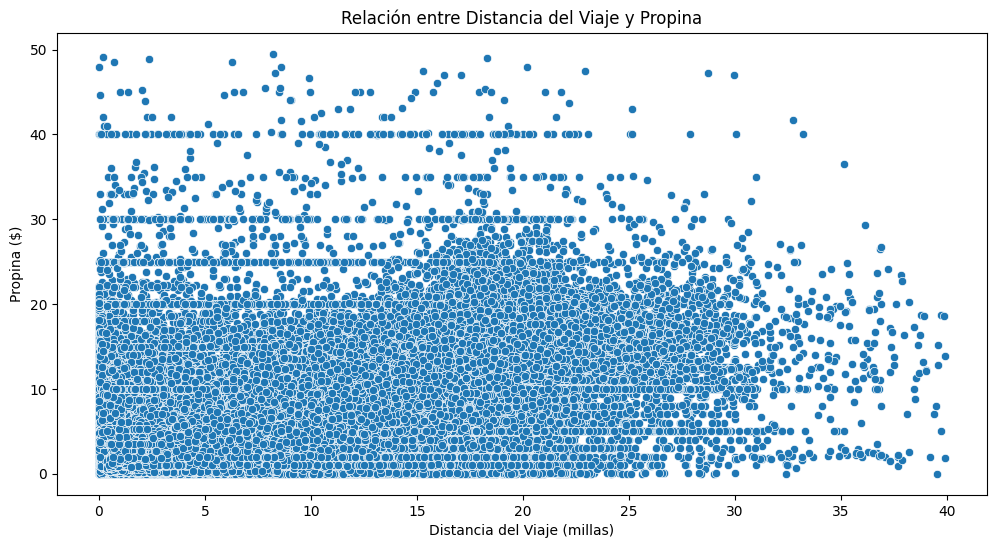

In [30]:
# Filtrar datos para eliminar valores extremos 
taxi_data = taxi_data[(taxi_data['tip_amount'] > 0) & (taxi_data['tip_amount'] < 50) & (taxi_data['trip_distance'] > 0) & (taxi_data['trip_distance'] < 40)]

# Visualizar la relación entre distancia del viaje y propina
plt.figure(figsize=(12, 6))
sns.scatterplot(x='trip_distance', y='tip_amount', data=taxi_data)
plt.title('Relación entre Distancia del Viaje y Propina')
plt.xlabel('Distancia del Viaje (millas)')
plt.ylabel('Propina ($)')
plt.show()


Concentración de Puntos: Hay una concentración densa de puntos en el rango inferior de distancias y propinas. Esto sugiere que la mayoría de los viajes son cortos y con propinas relativamente bajas, lo cual es típico en los servicios de taxi urbanos.

Rango de Propinas: Aunque la propina varía, hay una tendencia a dar propinas que caen dentro de ciertos rangos (por ejemplo, $10, $20, $30, etc.), lo que se refleja en las líneas horizontales de puntos. Esto puede deberse a la tendencia de los pasajeros a redondear las propinas a números enteros o a dar propinas estándar.

Distancia Larga, Propina Alta: Hay algunos viajes con distancias más largas y propinas más altas, aunque estos son menos frecuentes. Esto podría indicar viajes desde o hacia lugares más alejados, como aeropuertos o viajes interurbanos, donde los pasajeros pueden estar más inclinados a dar propinas más generosas debido a la duración o importancia del viaje.

Ausencia de una Tendencia Clara: No hay una relación directa y clara entre la distancia y la propina, ya que los puntos están bastante dispersos. Si bien hay viajes más largos con propinas más altas, también hay muchos viajes largos con propinas bajas y viceversa. Esto sugiere que otros factores además de la distancia pueden influir en la cantidad de la propina, como la calidad del servicio, las preferencias personales del pasajero o las normas culturales de propinas.

Outliers: Los puntos dispersos que se encuentran a lo largo de la parte superior de la gráfica pueden considerarse outliers, donde las propinas son inusualmente altas para la distancia recorrida. Esto podría deberse a la generosidad de ciertos pasajeros, tarifas de servicio excepcionales, o posiblemente errores en los datos.